# Training to label with BERT and Cleanlab
In this notebook, we'll use the labels that we have generated and checked with [Cleanlab](https://github.com/cgnorthcutt/cleanlab) to build a classifier using BERT embeddings to label the remaining data. We'll check our results with Cleanlab and adjust as necessary.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
from tqdm import tqdm
from random import sample
from sklearn.model_selection import train_test_split
import numpy as np 
import cleanlab
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import models, layers
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

import os
import sys
import inspect
from pathlib import Path 
currentdir = Path.cwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from mlyoucanuse.embeddings import get_embeddings_index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

I0412 21:01:54.837924 4709707200 file_utils.py:38] PyTorch version 1.4.0 available.
I0412 21:01:54.839154 4709707200 file_utils.py:54] TensorFlow version 2.1.0 available.
I0412 21:01:55.094659 4709707200 textcleaner.py:37] 'pattern' package not found; tag filters are not available for English
Using TensorFlow backend.


device(type='cpu')

In [3]:
occs_df = pd.read_csv('occupations.wikidata.all.gnews.labeled.final.csv', sep='\t')
occs_df.head()

,item_id,occupation_count,occupation,description,in_google_news,language_detected,source,label,labeled_by,label_error_reason
0,82955,606008,politician,"person involved in politics, person who holds ...",1,en,wikidata,1,human,NaN
1,189290,33481,military officer,member of an armed force or uniformed service ...,0,en,wikidata,-1,NaN,NaN
2,131512,8887,farmer,person that works in agriculture,1,da,wikidata,1,human,NaN
3,1734662,2012,cartographer,person preparing geographical maps,1,ia,wikidata,1,human,NaN
4,294126,323,land surveyor,profession,0,tr,wikidata,-1,NaN,NaN


In [4]:
pos_eg = occs_df.query('label==1')['occupation'].tolist()
neg_eg = occs_df.query('label==0')['occupation'].tolist()
print(f"Positive examples: {len(pos_eg):,}; Negative examples {len(neg_eg):,}")

Positive examples: 2,432; Negative examples 1,651


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

I0412 21:02:01.401956 4709707200 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt from cache at /Users/todd/.cache/torch/transformers/cee054f6aafe5e2cf816d2228704e326446785f940f5451a5b26033516a4ac3d.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [6]:
model = BertModel.from_pretrained('bert-large-cased')
model.eval()
model.to(device)
device

I0412 21:02:02.178060 4709707200 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json from cache at /Users/todd/.cache/torch/transformers/90deb4d9dd705272dc4b3db1364d759d551d72a9f70a91f60e3a1f5e278b985d.960df871e8c3e87cb781ccdbdd12a3c1e0ad83b173a9754bd183354449046e38
I0412 21:02:02.179345 4709707200 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_po

device(type='cpu')

## Here's an example of how we'll use BERT to provide embeddings for the text of an occupation label

In [7]:
input_ids = torch.tensor(tokenizer.encode("The quick brown fox jumped over the lazy dog.")).unsqueeze(0).to(device)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
last_hidden_states.detach()
print(last_hidden_states.shape)
text_embedding = last_hidden_states[0][0]
print(text_embedding.shape)

torch.Size([1, 12, 1024])
torch.Size([1024])


# Generate X; BERT embeddings for each Occupation we labeled

In [8]:
X =[]
with torch.no_grad():
    for name in tqdm(pos_eg, total=len(pos_eg)):
        input_ids = torch.tensor(tokenizer.encode(name)).unsqueeze(0).to(device)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        X.append(last_hidden_states[0][0].detach().cpu().numpy())
    for name in tqdm(neg_eg, total=len(neg_eg)):
        input_ids = torch.tensor(tokenizer.encode(name)).unsqueeze(0).to(device)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        X.append(last_hidden_states[0][0].detach().cpu().numpy())
X = np.array(X)
X.shape

100%|██████████| 1651/1651 [03:55<00:00,  7.01it/s]


(4083, 1024)

In [9]:
unlabeled = occs_df.query("label==-1")['occupation'].tolist()
unlabeled_X = []
with torch.no_grad():
    for name in tqdm(unlabeled, total=len(unlabeled)):
        input_ids = torch.tensor(tokenizer.encode(name)).unsqueeze(0).to(device)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        unlabeled_X.append(last_hidden_states[0][0].detach().cpu().numpy())
unlabeled_X = np.array(unlabeled_X)
unlabeled_X.shape

100%|██████████| 6891/6891 [17:26<00:00,  6.59it/s]


(6891, 1024)

## Split our data into train, validation and test sets

In [10]:
y = np.concatenate([np.ones(len(pos_eg), dtype=np.int64), np.zeros(len(neg_eg), dtype=np.int64)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=12)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, train_size=.5, random_state=12)
X.shape, y.shape

((4083, 1024), (4083,))

## Build a simple model

In [56]:
model = models.Sequential([
    layers.Dense(512, input_shape=(1024,), activation='relu'),
    layers.Dropout(.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_validation, y_validation),
                    verbose=0)

## Evaluate and adjust as necessary

In [57]:
res = model.evaluate(X_train, y_train)
print(f"Train results: loss {res[0]:.3f} acc: {res[1]:.3f}")
res =  model.evaluate(X_validation, y_validation)
print(f"Validation results: loss {res[0]:.3f} acc: {res[1]:.3f}")
res = model.evaluate(X_test, y_test)
print(f"Test results: loss {res[0]:.3f} acc: {res[1]:.3f}")

3266/3266 [==============================] - 0s 35us/sample - loss: 0.0725 - accuracy: 0.9715
Train results: loss 0.073 acc: 0.972
409/409 [==============================] - 0s 39us/sample - loss: 0.3905 - accuracy: 0.8704
Validation results: loss 0.391 acc: 0.870
408/408 [==============================] - 0s 47us/sample - loss: 0.3022 - accuracy: 0.8971
Test results: loss 0.302 acc: 0.897


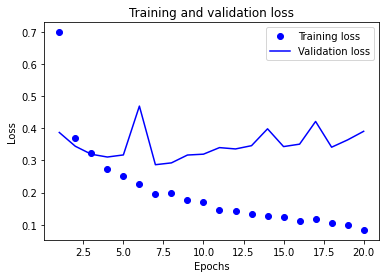

In [58]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Train final model

In [28]:
final_train_x = np.vstack((X_train, X_test)) 
final_train_y = np.hstack((y_train, y_test))

model = models.Sequential([
    layers.Dense(512, input_shape=(1024,), activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(final_train_x,
                    final_train_y,
                    epochs=7,
                    batch_size=128,
                    validation_data=(X_validation, y_validation),
                   verbose=0)

## Make Predictions

In [29]:
predictions = {}
for idx, word in tqdm(enumerate(unlabeled)):
    res = model.predict(unlabeled_X[idx].reshape(1, -1))
    predictions[word] = res[0][0]

6891it [02:21, 48.60it/s]


## Update our dataset with the BERT predictions

In [30]:
for occ in tqdm(predictions, total=len(predictions)):
    if occ in occs_df['occupation'].tolist():
        the_row = occs_df[occs_df['occupation'] == occ]
        the_index = the_row.index[0]
        occs_df.loc[the_index, 'label'] = int(round(predictions[occ]))
        occs_df.loc[the_index, 'labeled_by'] = 'bert'

100%|██████████| 6891/6891 [00:21<00:00, 314.38it/s]


## Use Cleanlab to find potentially problematic labels
    * Get out-of-sample predicted probabilities using cross-validation
    * Compute confident joint
    * Find label errors    
    
## Step 1: Get out-of-sample predicted probabilities using cross-validation    

In [31]:
labeled_y = [int(round(val)) for  key,val in predictions.items() ]

all_X = np.vstack((X, unlabeled_X)) 
all_y = np.hstack((y, labeled_y))

# using a simple, non-optimized logistic regression classifier; the cross-validation will expose label weaknesses
psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    all_X, all_y, clf=LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs'))

## Step 2: Compute confident joint

In [33]:
def compute_confident_joint(psx, y, verbose=False):
    # Verify inputs
    psx = np.asarray(psx)

    # Find the number of unique classes if K is not given
    K = len(np.unique(y))

    # Estimate the probability thresholds for confident counting
    # You can specify these thresholds yourself if you want
    # as you may want to optimize them using a validation set.
    # By default (and provably so) they are set to the average class prob.
    thresholds = [np.mean(psx[:,k][y == k]) for k in range(K)] # P(s^=k|s=k)
    thresholds = np.asarray(thresholds)

    # Compute confident joint
    confident_joint = np.zeros((K, K), dtype = int)
    for i, row in enumerate(psx):
        y_label = y[i]
        # Find out how many classes each example is confidently labeled as
        confident_bins = row >= thresholds - 1e-6
        num_confident_bins = sum(confident_bins)
        # If more than one conf class, inc the count of the max prob class
        if num_confident_bins == 1:
            confident_joint[y_label][np.argmax(confident_bins)] += 1
        elif num_confident_bins > 1:
            confident_joint[y_label][np.argmax(row)] += 1

    # Normalize confident joint (use cleanlab, trust me on this)
    confident_joint = cleanlab.latent_estimation.calibrate_confident_joint(
        confident_joint, y)
    if verbose:
        cleanlab.util.print_joint_matrix(confident_joint)
    return confident_joint

confident_joint = compute_confident_joint(psx, all_y)

## Step 3: Find label errors

In [36]:
def find_label_errors(confident_joint, y, verbose=False):
    # We arbitrarily choose at least 5 examples left in every class.
    # Regardless of whether some of them might be label errors.
    MIN_NUM_PER_CLASS = 5
    # Leave at least MIN_NUM_PER_CLASS examples per class.
    # NOTE prune_count_matrix is transposed (relative to confident_joint)
    prune_count_matrix = cleanlab.pruning.keep_at_least_n_per_class(
        prune_count_matrix=confident_joint.T,
        n=MIN_NUM_PER_CLASS,
    )
    K = len(np.unique(y)) # number of unique classes
    y_counts = np.bincount(y)
    noise_masks_per_class = []
    # For each row in the transposed confident joint
    for k in range(K):
        noise_mask = np.zeros(len(psx), dtype=bool)
        psx_k = psx[:, k]
        if y_counts[k] > MIN_NUM_PER_CLASS:  # Don't prune if not MIN_NUM_PER_CLASS
            for j in range(K):  # noisy label index (k is the true label index)
                if k != j:  # Only prune for noise rates, not diagonal entries
                    num2prune = prune_count_matrix[k][j]
                    if num2prune > 0:
                        # num2prune'th largest p(classk) - p(class j)
                        # for x with noisy label j
                        margin = psx_k - psx[:, j]
                        y_filter = y == j
                        threshold = -np.partition(
                            -margin[y_filter], num2prune - 1
                        )[num2prune - 1]
                        noise_mask = noise_mask | (y_filter & (margin >= threshold))
            noise_masks_per_class.append(noise_mask)
        else:
            noise_masks_per_class.append(np.zeros(len(s), dtype=bool))

    # Boolean label error mask
    label_errors_bool = np.stack(noise_masks_per_class).any(axis=0)

     # Remove label errors if given label == model prediction
    for i, pred_label in enumerate(psx.argmax(axis=1)):
        # np.all let's this work for multi_label and single label
        if label_errors_bool[i] and np.all(pred_label == y[i]):
            label_errors_bool[i] = False

    # Convert boolean mask to an ordered list of indices for label errors
    label_errors_idx = np.arange(len(y))[label_errors_bool]
    # self confidence is the holdout probability that an example
    # belongs to its given class label
    self_confidence = np.array(
        [np.mean(psx[i][y[i]]) for i in label_errors_idx]
    )
    margin = self_confidence - psx[label_errors_bool].max(axis=1)
    label_errors_idx = label_errors_idx[np.argsort(margin)]
    label_errors_idx.sort()
    if verbose:
        print('Indices of label errors found by confident learning:')
        print('Note label errors are sorted by likelihood of being an error')
        print('but here we just sort them by index for comparison with above.')
        print(np.array(label_errors_idx))
    return label_errors_idx

label_errors_idx = find_label_errors(confident_joint, all_y)

## Print out questionable labels and their existing scores for manual review

In [39]:
idx_name = {idx : name for idx, name in enumerate(pos_eg + neg_eg + unlabeled)}
# we'll sort the bad labels for easier review
questionable_good = []
questionable_bad = []
for bad_idx in label_errors_idx:
    true_name = idx_name[bad_idx]
    the_idx = occs_df.index[ occs_df['occupation'] == true_name].tolist()[0]
    if int(occs_df.iloc[the_idx]['label']) ==0:
        questionable_bad.append((occs_df.iloc[the_idx]['occupation'], occs_df.iloc[the_idx]['label']))
    if int(occs_df.iloc[the_idx]['label']) ==1:
        questionable_good.append((occs_df.iloc[the_idx]['occupation'], occs_df.iloc[the_idx]['label']))
for name, label in questionable_good + questionable_bad:
    print('"{}", {}'.format(name, label))

"playwright", 1
"Goliard", 1
"feminist", 1
"sculptor", 1
"academic", 1
"astronaut", 1
"printer", 1
"industrialist", 1
"bobsledder", 1
"paleontologist", 1
"anarchist", 1
"pirate", 1
"rikishi", 1
"crank", 1
"minister", 1
"duke", 1
"mullah", 1
"count", 1
"knight", 1
"runner", 1
"sniper", 1
"bartender", 1
"socialist", 1
"private sector employee", 1
"venture capitalist", 1
"mime", 1
"Patriot", 1
"corporal", 1
"gladiator", 1
"healer", 1
"prior", 1
"unemployed", 1
"baritone", 1
"counsel", 1
"Mohel", 1
"Gendarme", 1
"Pythia", 1
"Painter", 1
"Studienrat", 1
"censor", 1
"General", 1
"Freedom Fighters", 1
"comic", 1
"boss", 1
"hobo", 1
"Bedel", 1
"virgin", 1
"Shah", 1
"Hakim", 1
"judicial commissioner", 1
"partner", 1
"champion", 1
"Gurkha", 1
"Rangatira", 1
"Poeta", 1
"Revolutionary", 1
"Mawla", 1
"Monsieur", 1
"Korporal", 1
"Fundi", 1
"Patrick", 1
"Cacique", 1
"Archer", 1
"Sepoy", 1
"Thuggee", 1
"Richter", 1
"airport security", 1
"spouse", 1
"parent", 1
"MasterChef", 1
"Sexton", 1
"Hostess", 1


## Update the dataframe with manually adjusted labels

In [41]:
bad_bert_occs = ["shamakhi dancers", "circus arts", "yaksha", "Protestant theology", "architectural photography", "lumières", "consumer protection", "Jerome Mayo Greenberg", "role-playing game", "media literacy", "Pensioner Guards", "social anthropology", "Aviation historians", "short story", "communication medium", "bleachery", "video on demand", "armed struggle", "traditional song", "Rugby league match officials", "zootechnics", "special effects", "plastic surgery", "male prostitution", "deported French resistance", "china painting", "Perm Governorate", "Aalto University", "A Few Good Men", "beer pouring", "transport planning", "Chinese calligraphy", "local government", "natural philosophy", "petroleum-gas industry", "Transactions of the Royal Society of Tropical Medicine and Hygiene", "local history", "fackskolelärare", "digital photography", "social engagement", "Principle of Aberdeen University", "local authority", "computational science", "animal control service", "skolförestånderska", "Academy of Finland", "sigillography", "voice-over", "musical instrument", "Salinas de Ibargoiti", "Saint Petersburg State University", "Tobolsk Governorate", "General Francos's opposition", "Erivan Governorate", "staff and line", "Người dẫn chương trình truyền hình (chương trình TV)", "製本職人", "29 January 28", "Brigade RISTA - Electronic Warfare Intelligence", "Bomberos Voluntarios (Guatemala)", "London South Bank University", "supreme court", "Gubkin University", "High Priests of Amun", "community service", "Postgraduate Work", "Old lesbians: Gendered histories and persistent challenges.", "Canvas print", "theatrical makeup", "list of type designers", "Nazi plunder", "Domestikos", "Catholicos of All Armenians", "conservation movement", "arts administration", "Medical Specimens", "political analysis", "Shadow Theatre", "capo dei capi", "Letrados", "La Révolution prolétarienne", "Ña Catita", "Sofer", "skogsägare", "akademifogde", "organizational leadership", "Carabinieri", "furniture construction", "capitano del popolo", "Željko Ražnatović", "土木技師", "space exploration", "major police MVD", "dollmaking"]
bert_good_occs = ["Ambassadeur", "Chief Executive", "Named Professor", "folk hero", "cinephile", "peasant", "District Chief Executive", "scholar of the bible as literature", "Captain of the guard", "marxist", "Werkmeister", "Franciscan", "public figure", "land surveyor in Poland", "Member of the Congress of Deputies of Spain", "Jägermeister", "galley slave", "Member of Parliament in the Parliament of England", "Young Guard", "madam", "pietist", "Nazi", "patriarch", "Judge Advocate General of the Armed Forces", "competition judge", "diving instructor", "King of Jerusalem", "Tournament director", "Deputy Commander, ROK/US Combined Forces Command", "proselyte", "principal of Uppsala University", "headmaster in France", "reiki master", "Spiker", "combined track and field event athlete", "mayor of Albacete", "medical assistant", "research assistant", "Universal Esperanto Association committee member", "groom", "personality", "celebrity", "centenarian", "Naturaliste", "superhero", "sinecure", "General Officer Commanding", "revenger", "Candidate of Biology Sciences", "human", "Freiherr", "tsarina", "member of the Senate of France", "erudite", "delegate", "passenger", "youth sports minister", "vegetarian", "wanker", "streamer", "mythological king", "internet celebrity", "Polymath", "charcoal burner", "Director-General of the National Heritage Board", "General of the Infantry", "streaker", "pacemaker", "person of short stature", "Iceman", "vase painter", "mother", "patostreamer", "schoolbook publisher", "registrar", "supercentenarian", "fado singer", "Tattooed Lady", "maltster", "cure doctor", "Jedi", "elder", "building contractor", "court Jew"]

print(f"Dataframe length before update {len(occs_df):,}")
for occ in tqdm(bert_good_occs, total=len(bert_good_occs)):
    if occ in occs_df['occupation'].tolist():
        the_row = occs_df[occs_df['occupation'] == occ ]
        the_index = the_row.index[0]
        occs_df.loc[the_index, 'label'] = 1
        occs_df.loc[the_index, 'labeled_by'] = 'cleanlab'
for occ in tqdm(bad_bert_occs, total=len(bad_bert_occs)):
    if occ in occs_df['occupation'].tolist():
        the_row = occs_df[occs_df['occupation'] == occ ]
        the_index = the_row.index[0]
        occs_df.loc[the_index, 'label'] = 0
        occs_df.loc[the_index, 'labeled_by'] = 'cleanlab'    
print(f"Dataframe length after update {len(occs_df):,}")    

 37%|███▋      | 31/84 [00:00<00:00, 309.37it/s]

Dataframe length before update 10,974


100%|██████████| 94/94 [00:00<00:00, 330.81it/s]

Dataframe length after update 10,974


## Cleanlab, 2nd pass

In [48]:
def print_label_names(idx_label_map, label_errors_idx):
    label_error_names = [idx_label_map.get(tmp) for tmp in label_errors_idx]

    # We'll sort the labels alphabetically and by label value for easier manual review
    label_error_names.sort()
    pos_labels = []
    neg_labels = []
    for name in label_error_names:
        key_name = name.replace('_', ' ')
        val = int(occs_df[occs_df['occupation'] == key_name].label )
        if val ==1:
            pos_labels.append((key_name, val))
        else:
            neg_labels.append((key_name, val))
    for key_name, val in pos_labels + neg_labels:
        print('"{}", {}'.format(key_name, val))


In [49]:
good_occs = occs_df.query("in_google_news ==1 and label ==1")['occupation'].tolist()
bad_occs = occs_df.query("in_google_news ==1 and label ==0")['occupation'].tolist()
y = np.concatenate([np.ones(len(good_occs), dtype=np.int32), np.zeros(len(bad_occs), dtype=np.int32)])

X =[]
model = BertModel.from_pretrained('bert-large-cased')
model.eval()
model.to(device)
with torch.no_grad():
    for name in tqdm(good_occs, total=len(good_occs)):
        input_ids = torch.tensor(tokenizer.encode(name)).unsqueeze(0).to(device)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        X.append(last_hidden_states[0][0].detach().cpu().numpy())
    for name in tqdm(bad_occs, total=len(bad_occs)):
        input_ids = torch.tensor(tokenizer.encode(name)).unsqueeze(0).to(device)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        X.append(last_hidden_states[0][0].detach().cpu().numpy())
X = np.array(X)
X.shape

all_words = good_occs + bad_occs

# We'll save the mapping of index to words for decoding
idx_label_map = {}
for idx, name in enumerate(all_words):
    idx_label_map[idx]= name
    
psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    X, y, clf=LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs'))

confident_joint = compute_confident_joint(psx, y)

label_errors_idx = find_label_errors(confident_joint, y)

print_label_names(idx_label_map, label_errors_idx)   

I0412 22:33:45.533503 4709707200 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json from cache at /Users/todd/.cache/torch/transformers/90deb4d9dd705272dc4b3db1364d759d551d72a9f70a91f60e3a1f5e278b985d.960df871e8c3e87cb781ccdbdd12a3c1e0ad83b173a9754bd183354449046e38
I0412 22:33:45.535501 4709707200 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_po

"Abogado", 1
"Advokat", 1
"Archer", 1
"Assistant Secretary", 1
"Avocat", 1
"Bedel", 1
"Bokor", 1
"Buddhist", 1
"Burgess", 1
"Cacique", 1
"Censor", 1
"Dempster", 1
"Dewan", 1
"Drayman", 1
"Evangelist", 1
"Expeditor", 1
"Fechter", 1
"Freedom Fighters", 1
"Fundi", 1
"Gendarme", 1
"General", 1
"Grammarian", 1
"Gurkha", 1
"Hakim", 1
"Heir apparent", 1
"Hofmeister", 1
"Imagineer", 1
"Jihadi", 1
"Juris Doctor", 1
"Jägermeister", 1
"Khatib", 1
"Lascar", 1
"MasterChef", 1
"Mawla", 1
"Met Éireann", 1
"Mohel", 1
"Mormon missionary", 1
"Operator", 1
"Patrick", 1
"Poeta", 1
"Pythia", 1
"Rangatira", 1
"Reichsmarschall", 1
"Revolutionary", 1
"Richter", 1
"Rynda", 1
"Schiffer", 1
"Sepoy", 1
"Shah", 1
"Shihan", 1
"Soldat", 1
"Student", 1
"Thuggee", 1
"Tulku", 1
"Zen master", 1
"abbey", 1
"academic", 1
"artisan", 1
"associate", 1
"autopilot", 1
"ballet dancer", 1
"banker", 1
"baritone", 1
"baron", 1
"bartender", 1
"billionaire", 1
"communist", 1
"cook", 1
"corporal", 1
"counsel", 1
"count", 1
"counterin

In [52]:
print_label_names(idx_label_map, label_errors_idx)   

"Abogado", 1
"Advokat", 1
"Archer", 1
"Assistant Secretary", 1
"Avocat", 1
"Bedel", 1
"Bokor", 1
"Buddhist", 1
"Burgess", 1
"Cacique", 1
"Censor", 1
"Dempster", 1
"Dewan", 1
"Drayman", 1
"Evangelist", 1
"Expeditor", 1
"Fechter", 1
"Freedom Fighters", 1
"Fundi", 1
"Gendarme", 1
"General", 1
"Grammarian", 1
"Gurkha", 1
"Hakim", 1
"Heir apparent", 1
"Hofmeister", 1
"Imagineer", 1
"Jihadi", 1
"Juris Doctor", 1
"Jägermeister", 1
"Khatib", 1
"Lascar", 1
"MasterChef", 1
"Mawla", 1
"Met Éireann", 1
"Mohel", 1
"Mormon missionary", 1
"Operator", 1
"Patrick", 1
"Poeta", 1
"Pythia", 1
"Rangatira", 1
"Reichsmarschall", 1
"Revolutionary", 1
"Richter", 1
"Rynda", 1
"Schiffer", 1
"Sepoy", 1
"Shah", 1
"Shihan", 1
"Soldat", 1
"Student", 1
"Thuggee", 1
"Tulku", 1
"Zen master", 1
"abbey", 1
"academic", 1
"artisan", 1
"associate", 1
"autopilot", 1
"ballet dancer", 1
"banker", 1
"baritone", 1
"baron", 1
"bartender", 1
"billionaire", 1
"communist", 1
"cook", 1
"corporal", 1
"counsel", 1
"count", 1
"counterin

In [53]:
bad_occs_manual=[ "Freedom Fighters", "Met Éireann", "autopilot", "counterintelligence", "pastry shop", ] 
good_occs_manual = [ "Faujdar", "MV Explorer", "Naik", "Raja", "Rinpoche", "Zamindar", "daimyo", "father", ]
print(f"Dataframe length before update {len(occs_df):,}")
for occ in tqdm(good_occs_manual, total=len(good_occs_manual)):
    if occ in occs_df['occupation'].tolist():
        the_row = occs_df[occs_df['occupation'] == occ ]
        the_index = the_row.index[0]
        occs_df.loc[the_index, 'label'] = 1
        occs_df.loc[the_index, 'labeled_by'] = 'cleanlab'
for occ in tqdm(bad_occs_manual, total=len(bad_occs_manual)):
    if occ in occs_df['occupation'].tolist():
        the_row = occs_df[occs_df['occupation'] == occ ]
        the_index = the_row.index[0]
        occs_df.loc[the_index, 'label'] = 0
        occs_df.loc[the_index, 'labeled_by'] = 'cleanlab'    
print(f"Dataframe length after update {len(occs_df):,}")    

100%|██████████| 5/5 [00:00<00:00, 232.00it/s]

Dataframe length before update 10,974
Dataframe length after update 10,974


In [54]:
occs_df.to_csv('occupations.wikidata.all.labeled.csv', index=False, sep='\t')

In [55]:
occs_df.head()

,item_id,occupation_count,occupation,description,in_google_news,language_detected,source,label,labeled_by,label_error_reason
0,82955,606008,politician,"person involved in politics, person who holds ...",1,en,wikidata,1,human,NaN
1,189290,33481,military officer,member of an armed force or uniformed service ...,0,en,wikidata,1,bert,NaN
2,131512,8887,farmer,person that works in agriculture,1,da,wikidata,1,human,NaN
3,1734662,2012,cartographer,person preparing geographical maps,1,ia,wikidata,1,human,NaN
4,294126,323,land surveyor,profession,0,tr,wikidata,1,bert,NaN


## The dataset is now labeled and verified. Next we will use it to generate negative examples in preparing the Employers dataset